# IMPORTING LIBRARIES


In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re
import nltk  
nltk.download('stopwords') 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from collections import Counter
import cufflinks as cf
cf.go_offline()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# IMPORTING THE FILES FROM DESKTOP TO GOOGLE COLLAB


In [66]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [0]:
import io
train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))

In [69]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


# GETTING TO KNOW TRAIN AND TEST DATA


In [0]:
test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))

In [71]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [72]:
test.shape,train.shape

((3263, 4), (7613, 5))

In [129]:
missing = train.isnull().sum() #Checking all the NULL values ing training data
missing

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

In [0]:
train['length'] = train['text'].apply(len) #Creating a new column for length of text

# USING WORDCLOUD

In [0]:
STOPWORDS.add('https') # remove htps to the world Cloud

In [0]:
stopwords = set(STOPWORDS) 

In [0]:
STOPWORDS.add('https')  # add https to the world Cloud STOPWORDS

def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12) ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

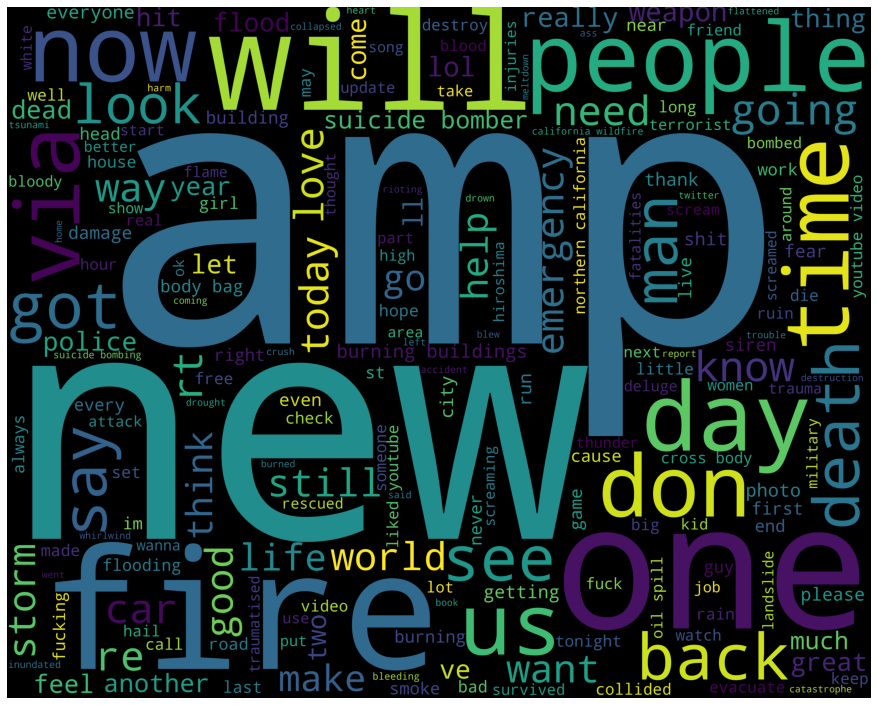

In [131]:
text = train.text.values
Plot_world(text)

# CLEANING OF DATA

In [80]:
 train.loc[train['text'].str.contains('http')].target.value_counts() #Here we cannot do train.text beacuse it doesnt return a datafram 

1    2172
0    1799
Name: target, dtype: int64

In [0]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') 

In [0]:
def remove_html(text):
  no_html = pattern.sub(' ',text) #Created a pattern object above which ahd a method sub which was used to replace pattern with space in the text
  return no_html

In [0]:
train['text'] = train['text'].apply(lambda x : remove_html(x))

In [0]:
test['text']=test['text'].apply(lambda x : remove_html(x))

In [0]:
def clean_text(text):
    # Making Sure everything is a word no numbers  
    text = re.sub('[^a-zA-Z]', ' ', text)  

    text = text.lower()  

    # split to array(default delimiter is " ") 
    text = text.split()  
    
    text = [w for w in text if not w in set(stopwords)] 

    text = ' '.join(text)    
            
    return text

In [0]:

train['text'] = train['text'].apply(lambda x : clean_text(x))

In [0]:
text = train.text[3]
print(text)
clean_text(text)

In [0]:
def counter_word(text):
  count = Counter()
  for i in text.values:
    for word in i.split():
      count[word]+=1
  return count

In [0]:
text_values = train['text']

# DEVELOPING A MODEL

In [0]:
counter = counter_word(text_values)

In [0]:
vocab_size = len(counter) #for developing vocabulary
embedding_dim = 32 #The embedding Dimension
max_length = 20 # Max length of senteces in train['text]
trunc_type='post' # If length graeter than max_length than trucate from end
padding_type='post' # If less than padd from end
oov_tok = "<XXX>" # out of Vocab token
training_size=6090 
seq_len = 12


In [0]:
training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]
# 80-20 split of train and test data

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences) #ENCODES THE DATA

In [0]:
word_index = tokenizer.word_index # RETURNS A DICTIONARY WITH KEY VALUE PAIRS

In [0]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [0]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [115]:
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')

Epoch 1/10
191/191 [==============================] - 5s 29ms/step - loss: 0.5576 - accuracy: 0.7023 - val_loss: 0.4556 - val_accuracy: 0.7991
Epoch 2/10
191/191 [==============================] - 5s 25ms/step - loss: 0.2988 - accuracy: 0.8785 - val_loss: 0.4950 - val_accuracy: 0.7735
Epoch 3/10
191/191 [==============================] - 5s 24ms/step - loss: 0.1649 - accuracy: 0.9411 - val_loss: 0.6440 - val_accuracy: 0.7413
Epoch 4/10
191/191 [==============================] - 5s 24ms/step - loss: 0.1137 - accuracy: 0.9639 - val_loss: 0.5978 - val_accuracy: 0.7262
Epoch 5/10
191/191 [==============================] - 5s 25ms/step - loss: 0.0917 - accuracy: 0.9722 - val_loss: 0.6810 - val_accuracy: 0.7295
Epoch 6/10
191/191 [==============================] - 5s 24ms/step - loss: 0.0762 - accuracy: 0.9739 - val_loss: 0.9665 - val_accuracy: 0.7085
Epoch 7/10
191/191 [==============================] - 5s 24ms/step - loss: 0.0636 - accuracy: 0.9767 - val_loss: 0.7752 - val_accuracy: 0.7452

In [116]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.557639,0.702299,0.455562,0.799081
1,0.298813,0.878489,0.495005,0.773473
2,0.164862,0.941051,0.643961,0.741300
3,0.113748,0.963875,0.597849,0.726198
4,0.091689,0.972250,0.681006,0.729481


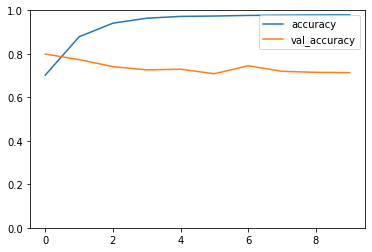

In [117]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1]);

In [118]:
predictions = model.predict_classes(testing_padded)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [0]:
from sklearn.metrics import classification_report,confusion_matrix

In [0]:
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

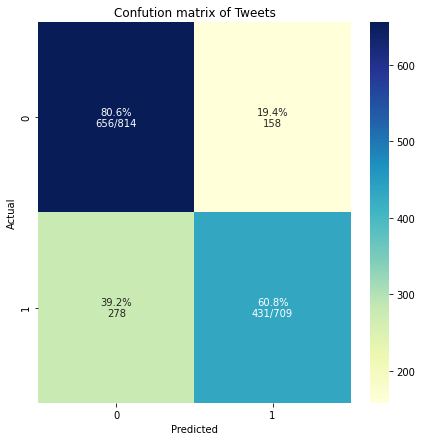

In [122]:
plot_cm(testing_labels,predictions, 'Confution matrix of Tweets', figsize=(7,7))

In [0]:
testing_sequences2 = tokenizer.texts_to_sequences(test.text)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
predictions = model.predict(testing_padded2)